In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import random
from datetime import datetime
from math import nan
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
import statsmodels.api as sm

%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_rows', 20)
pd.set_option('display.max_columns', None)

In [3]:
sns.set_style("whitegrid")

### 1. Import and clean data preliminarily

In [4]:
model_df1 = pd.read_csv('../dataset/model_df1.csv')

In [5]:
model_df1.shape

(21361, 74)

In [6]:
model_df1.head()

,match_api_id,offence_misc_CB_home,offence_misc_GK_home,offence_misc_MF_home,offence_misc_SB_home,offence_misc_ST_home,offence_misc_W_home,movement_CB_home,movement_GK_home,movement_MF_home,movement_SB_home,movement_ST_home,movement_W_home,passing_CB_home,passing_GK_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_CB_home,shooting_GK_home,shooting_MF_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_GK_home,defence_MF_home,defence_SB_home,defence_ST_home,defence_W_home,goalkeeping_CB_home,goalkeeping_GK_home,goalkeeping_MF_home,goalkeeping_SB_home,goalkeeping_ST_home,goalkeeping_W_home,offence_misc_CB_away,offence_misc_GK_away,offence_misc_MF_away,offence_misc_SB_away,offence_misc_ST_away,offence_misc_W_away,movement_CB_away,movement_GK_away,movement_MF_away,movement_SB_away,movement_ST_away,movement_W_away,passing_CB_away,passing_GK_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_CB_away,shooting_GK_away,shooting_MF_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_GK_away,defence_MF_away,defence_SB_away,defence_ST_away,defence_W_away,goalkeeping_CB_away,goalkeeping_GK_away,goalkeeping_MF_away,goalkeeping_SB_away,goalkeeping_ST_away,goalkeeping_W_away,result
0,483130,70.16,51.33,78.84,74.59,75.34,78.00,64.00,49.00,74.34,66.83,75.66,72.66,59.67,41.33,78.00,62.66,64.16,74.34,49.12,19.50,73.50,56.50,63.50,69.25,77.62,29.50,66.62,81.50,49.38,78.88,19.12,81.25,19.62,18.88,18.38,17.75,63.84,54.33,70.84,70.34,64.75,73.34,55.00,34.67,66.83,68.84,67.84,71.16,51.67,44.67,73.00,67.34,53.16,71.00,41.88,23.50,57.88,53.38,63.62,70.25,69.41,33.75,70.75,64.50,36.71,61.75,18.12,73.50,19.00,17.25,18.25,14.50,win
1,483131,59.34,23.50,63.25,41.34,65.00,70.16,53.00,35.67,66.16,44.16,64.83,64.25,53.17,38.33,63.17,43.34,57.66,64.75,34.62,22.00,46.12,35.62,67.12,64.19,64.50,30.33,45.42,59.12,48.12,55.81,17.25,72.50,17.62,14.62,14.25,14.88,65.50,32.33,64.44,72.00,68.00,64.16,54.66,21.00,68.67,63.00,67.67,67.00,63.84,37.33,59.00,61.34,49.33,59.50,54.00,18.75,51.42,58.12,69.25,59.75,69.50,18.75,66.50,63.62,32.50,34.12,19.12,69.25,18.25,19.88,18.00,17.38,win
2,483133,71.66,34.67,77.00,77.66,82.67,80.66,68.00,22.67,72.89,72.67,87.67,79.16,71.00,41.00,76.00,77.34,68.67,79.16,53.00,22.25,74.50,64.38,81.50,66.12,75.31,19.75,57.42,74.38,42.75,67.00,20.12,82.00,16.33,13.12,16.25,19.25,69.67,39.67,72.78,63.33,65.00,64.66,63.17,34.33,68.44,60.17,57.00,70.67,68.66,38.67,66.89,60.50,54.00,59.34,55.50,20.75,61.67,42.00,34.75,67.50,72.25,31.50,60.33,70.50,63.50,33.62,17.50,75.75,17.92,18.62,15.75,18.62,win
3,483134,59.66,70.00,71.17,36.67,66.50,69.17,57.84,58.00,76.50,39.16,71.83,58.84,51.66,66.67,68.16,53.16,62.00,63.66,45.69,36.75,60.88,30.75,65.62,43.62,71.50,65.75,35.38,51.88,37.38,68.50,18.50,17.00,13.88,42.50,16.88,18.25,63.17,34.67,76.67,70.92,66.66,84.34,63.50,43.33,76.17,73.42,75.34,72.34,53.16,40.33,77.66,71.25,56.33,74.50,35.25,17.75,64.88,64.69,63.25,53.50,71.88,24.50,68.88,74.50,28.25,65.38,17.38,82.00,17.50,18.88,13.12,17.75,win
4,483135,65.41,40.33,71.00,60.67,57.67,68.17,69.17,40.33,68.45,56.66,63.33,76.83,71.00,38.33,64.78,49.34,48.00,69.50,44.12,18.50,57.92,46.38,63.00,72.00,80.38,29.00,62.75,47.75,39.75,40.50,19.12,79.25,19.00,17.38,16.50,14.50,69.66,29.33,77.11,70.34,79.33,67.16,64.83,38.00,76.56,70.00,81.33,70.50,65.00,37.00,74.78,70.50,65.67,63.84,48.12,18.50,72.17,58.62,65.25,64.75,77.50,29.25,66.92,72.62,37.75,60.38,19.50,67.25,18.50,18.12,17.50,19.50,tie


In [7]:
model_df1['result'].value_counts()

win     9804
lose    6161
tie     5396
Name: result, dtype: int64

- Home win has more observations than home lose

In [8]:
#drop columns that have less significant influence on match result by common sense
columns = model_df1.columns
new_columns = [col for col in columns if 'offence_misc_GK' not in col
                                  and 'movement_GK_' not in col
                                  and 'shooting_GK' not in col 
                                  and 'defence_GK' not in col
                                  and 'passing_GK' not in col
                                  and 'goalkeeping_CB' not in col
                                  and 'goalkeeping_MF' not in col
                                  and 'goalkeeping_SB' not in col
                                  and 'goalkeeping_ST' not in col
                                  and 'goalkeeping_W' not in col]

model_df1 = model_df1[new_columns]

In [9]:
model_df1.isna().sum()

match_api_id               0
offence_misc_CB_home       0
offence_misc_MF_home       0
offence_misc_SB_home    1303
offence_misc_ST_home       0
                        ... 
defence_SB_away         1339
defence_ST_away            0
defence_W_away          1795
goalkeeping_GK_away        0
result                     0
Length: 54, dtype: int64

- Missing data appear on position 'W' and 'SB'. It happened because of unique starting formations. The decision is to drop those rows after other feature engineering actions.

### 2. Check out outliers

In [10]:
model_df1_n = model_df1.drop('match_api_id', axis = 1)
model_df1_n = model_df1_n.dropna()
y = model_df1_n['result']
X = model_df1_n.drop(['result'], axis = 1)

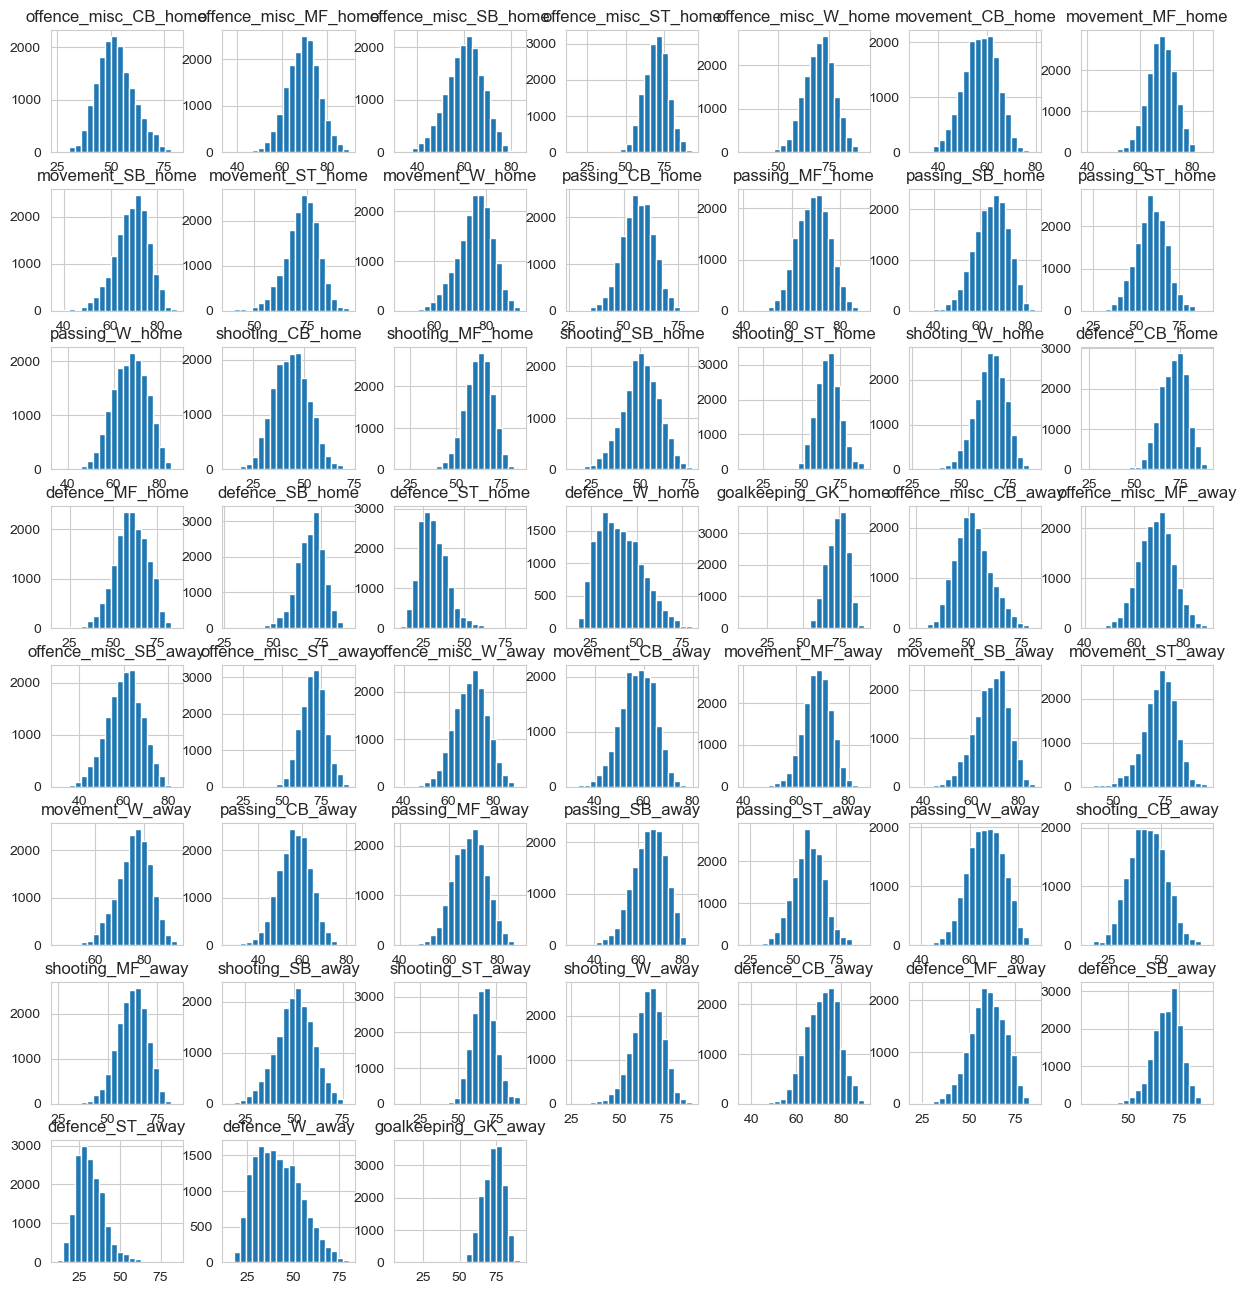

In [11]:
# A quick view of all columns distributions
X.hist(bins=20, figsize=(15, 16))
plt.show()

Most of the distributions are slightly skewed. A few has outliers.

In [12]:
X.describe()

,offence_misc_CB_home,offence_misc_MF_home,offence_misc_SB_home,offence_misc_ST_home,offence_misc_W_home,movement_CB_home,movement_MF_home,movement_SB_home,movement_ST_home,movement_W_home,passing_CB_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_CB_home,shooting_MF_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_MF_home,defence_SB_home,defence_ST_home,defence_W_home,goalkeeping_GK_home,offence_misc_CB_away,offence_misc_MF_away,offence_misc_SB_away,offence_misc_ST_away,offence_misc_W_away,movement_CB_away,movement_MF_away,movement_SB_away,movement_ST_away,movement_W_away,passing_CB_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_CB_away,shooting_MF_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_MF_away,defence_SB_away,defence_ST_away,defence_W_away,goalkeeping_GK_away
count,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.00000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000,16318.000000
mean,52.328355,69.184598,60.405941,69.836061,70.086973,57.456585,68.088178,68.924875,72.422614,75.868776,56.412486,68.881676,65.002067,58.732168,66.940533,43.764505,62.497220,50.398736,67.195680,65.241225,71.513951,60.042598,69.032454,31.380119,41.049258,73.421603,52.35517,69.023687,60.206177,69.834496,69.889159,57.486272,67.990058,68.789805,72.600900,75.608845,56.452446,68.738714,64.808804,58.870508,66.885222,43.723100,62.283511,50.152283,67.111190,64.911906,71.515812,60.250474,69.023492,31.482128,41.913875,73.428955
std,8.462973,7.045897,7.770183,7.841112,7.271680,7.024982,5.249828,7.171493,7.820079,6.731663,7.153378,6.759757,7.346583,8.929797,7.400457,8.639657,7.547397,9.510874,7.834411,7.908715,7.192370,9.357856,6.931253,8.622847,11.792154,6.894510,8.44041,6.968398,7.794827,7.823697,7.315976,6.957295,5.229638,7.190792,7.789078,6.791394,7.133977,6.696457,7.401950,8.943795,7.358108,8.608586,7.489428,9.438650,7.859957,8.070196,7.150439,9.422709,6.933347,8.728418,12.063365,6.935714
min,24.840000,36.140000,32.690000,15.330000,33.330000,30.670000,39.920000,36.830000,37.740000,47.000000,26.460000,40.160000,31.920000,21.330000,35.250000,12.880000,19.560000,15.000000,12.000000,26.500000,23.940000,17.620000,27.080000,11.000000,14.750000,8.830000,24.84000,40.890000,29.840000,15.330000,38.330000,30.670000,40.130000,36.330000,37.740000,44.340000,26.460000,40.090000,29.840000,21.330000,37.500000,15.000000,24.250000,16.250000,12.000000,25.500000,36.620000,21.250000,29.750000,11.000000,14.750000,9.000000
25%,46.280000,64.390000,55.330000,64.620000,65.250000,52.812500,64.690000,64.420000,67.840000,71.750000,51.580000,64.160000,60.000000,52.870000,61.750000,37.750000,57.520000,44.560000,61.920000,60.300000,66.500000,54.120000,64.652500,25.120000,31.750000,68.500000,46.34000,64.232500,55.000000,64.580000,64.900000,52.890000,64.610000,64.170000,68.000000,71.330000,51.660000,64.000000,59.840000,53.000000,61.780000,37.750000,57.390000,44.250000,61.810000,59.810000,66.500000,54.190000,64.620000,25.250000,32.380000,68.500000
50%,51.750000,69.450000,60.830000,70.000000,70.500000,57.675000,68.220000,69.580000,73.050000,76.470000,56.500000,69.070000,65.500000,58.940000,67.170000,43.880000,62.960000,50.620000,67.220000,65.690000,72.060000,60.210000,69.690000,30.250000,39.880000,74.190000,51.80000,69.280000,60.600000,70.000000,70.250000,57.750000,68.170000,69.420000,73.220000,76.160000,56.555000,68.9

- A few parameters look way below common range. 

In [13]:
z_scores = np.abs((X - X.mean()) / X.std())
outliers = z_scores > 4
outliers_rows = model_df1_n[outliers.any(axis=1)]

outliers_rows.shape

(305, 53)

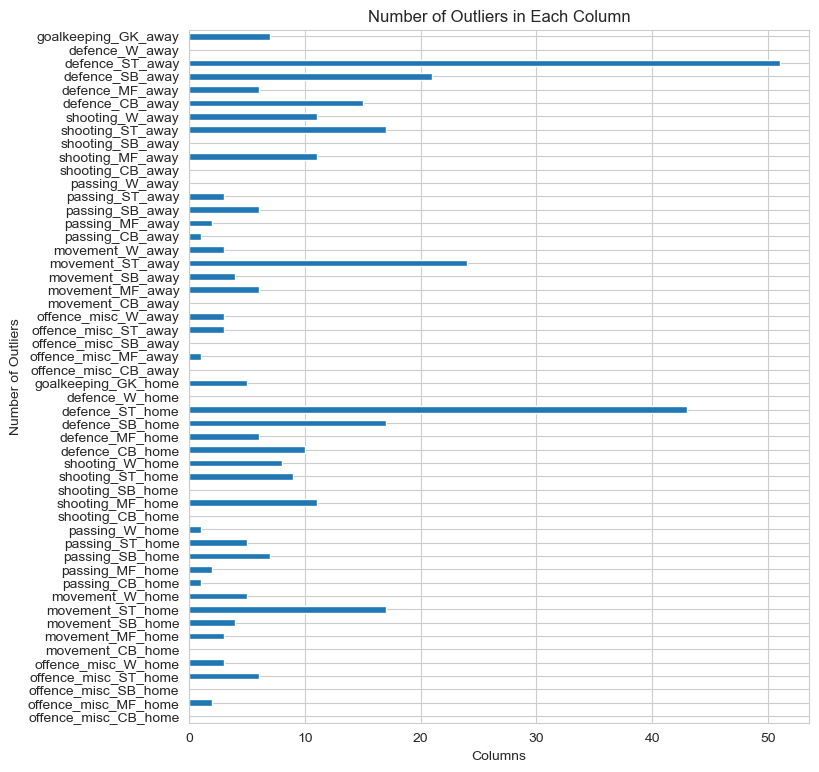

In [14]:
# Check which columns have the most outliers
outlier_counts = outliers.sum()
plt.figure(figsize=(8, 9))
outlier_counts.plot(kind='barh')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')
plt.title('Number of Outliers in Each Column')
plt.show()

Strikers have the most outliers. 


Check out the situation of one example

In [15]:
outliers_rows.head()

,offence_misc_CB_home,offence_misc_MF_home,offence_misc_SB_home,offence_misc_ST_home,offence_misc_W_home,movement_CB_home,movement_MF_home,movement_SB_home,movement_ST_home,movement_W_home,passing_CB_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_CB_home,shooting_MF_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_MF_home,defence_SB_home,defence_ST_home,defence_W_home,goalkeeping_GK_home,offence_misc_CB_away,offence_misc_MF_away,offence_misc_SB_away,offence_misc_ST_away,offence_misc_W_away,movement_CB_away,movement_MF_away,movement_SB_away,movement_ST_away,movement_W_away,passing_CB_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_CB_away,shooting_MF_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_MF_away,defence_SB_away,defence_ST_away,defence_W_away,goalkeeping_GK_away,result
2,71.66,77.00,77.66,82.67,80.66,68.00,72.89,72.67,87.67,79.16,71.00,76.00,77.34,68.67,79.16,53.00,74.50,64.38,81.50,66.12,75.31,57.42,74.38,42.75,67.00,82.00,69.67,72.78,63.33,65.00,64.66,63.17,68.44,60.17,57.00,70.67,68.66,66.89,60.50,54.00,59.34,55.50,61.67,42.00,34.75,67.50,72.25,60.33,70.50,63.50,33.62,75.75,win
3,59.66,71.17,36.67,66.50,69.17,57.84,76.50,39.16,71.83,58.84,51.66,68.16,53.16,62.00,63.66,45.69,60.88,30.75,65.62,43.62,71.50,35.38,51.88,37.38,68.50,17.00,63.17,76.67,70.92,66.66,84.34,63.50,76.17,73.42,75.34,72.34,53.16,77.66,71.25,56.33,74.50,35.25,64.88,64.69,63.25,53.50,71.88,68.88,74.50,28.25,65.38,82.00,win
19,66.50,72.50,62.50,73.67,82.00,64.16,69.09,60.84,81.34,67.16,63.34,72.34,55.92,74.84,79.84,54.00,57.75,48.75,68.75,71.00,74.12,66.12,70.19,55.50,41.96,75.50,69.66,77.11,70.34,78.33,72.50,64.83,76.56,70.00,78.00,69.16,65.00,74.78,70.50,73.67,76.16,48.12,72.17,58.62,63.25,60.94,77.50,66.92,72.62,74.75,59.38,67.25,win
21,58.17,67.56,66.00,70.67,74.75,59.16,67.67,61.67,72.00,75.84,53.84,61.89,58.17,75.33,63.34,38.25,60.58,46.12,64.25,68.62,68.50,55.75,66.12,66.00,40.46,73.50,63.17,76.78,70.92,71.33,84.34,63.50,76.67,73.42,71.00,72.34,53.16,76.44,71.25,56.33,74.50,35.25,65.92,64.69,65.50,53.50,71.88,61.42,74.50,36.50,65.38,82.00,lose
23,69.50,77.11,48.33,78.33,75.17,68.83,76.56,46.16,78.00,77.00,67.16,74.78,47.84,73.67,79.00,54.75,72.17,26.62,63.25,64.00,74.88,66.92,52.75,74.75,62.12,19.75,73.25,78.67,64.66,79.84,74.50,70.66,76.00,59.34,80.50,75.66,66.00,80.00,55.50,72.16,71.16,42.88,80.12,44.38,72.62,66.00,77.00,67.00,77.75,45.00,58.25,81.25,win


In [16]:
import sqlite3
with sqlite3.connect('../dataset/database.sqlite') as con:
    matches = pd.read_sql_query("SELECT * from Match", con)
with sqlite3.connect('../dataset/database.sqlite') as con:
    player_detail = pd.read_sql_query("SELECT * from Player_Attributes", con)

In [17]:
# Check the match which shooting_ST_home = 12
matches.query('match_api_id == 483333')

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
4902,4903,4769,4769,2008/2009,21,2009-01-17 00:00:00,483333,8592,9746,2,0,1.0,2.0,4.0,6.0,8.0,1.0,3.0,5.0,7.0,9.0,5.0,1.0,2.0,4.0,6.0,8.0,2.0,4.0,6.0,8.0,4.0,6.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,10.0,10.0,31293.0,25541.0,26138.0,40022.0,26052.0,33464.0,26112.0,24116.0,78185.0,40060.0,37254.0,41186.0,46645.0,39977.0,46447.0,26118.0,46650.0,46656.0,33108.0,26405.0,46660.0,94045.0,None,None,None,None,None,None,None,None,1.33,4.5,11.0,1.3,4.25,10.0,1.3,4.4,8.5,1.33,4.0,8.0,NaN,NaN,NaN,1.3,4.2,8.5,1.3,4.75,12.0,1.3,4.35,9.0,1.35,4.25,9.0,1.3,4.5,9.0


In [18]:
player_detail.query('player_api_id == 37254')

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
107760,107761,177485,37254,2015-09-21 00:00:00,72.0,75.0,right,medium,medium,10.0,11.0,13.0,27.0,13.0,12.0,10.0,10.0,22.0,19.0,43.0,59.0,45.0,67.0,39.0,24.0,47.0,32.0,76.0,10.0,21.0,19.0,11.0,12.0,18.0,12.0,11.0,12.0,76.0,71.0,64.0,66.0,79.0
107761,107762,177485,37254,2014-10-10 00:00:00,70.0,73.0,right,medium,medium,25.0,25.0,25.0,26.0,25.0,25.0,25.0,25.0,21.0,25.0,43.0,59.0,45.0,64.0,39.0,23.0,47.0,32.0,90.0,25.0,20.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,75.0,69.0,63.0,62.0,78.0
107762,107763,177485,37254,2014-09-18 00:00:00,70.0,73.0,right,medium,medium,25.0,25.0,25.0,26.0,25.0,25.0,25.0,25.0,21.0,25.0,43.0,59.0,45.0,64.0,39.0,23.0,47.0,32.0,90.0,25.0,20.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,75.0,69.0,63.0,62.0,78.0
107763,107764,177485,37254,2014-05-02 00:00:00,65.0,65.0,right,medium,low,35.0,69.0,71.0,53.0,60.0,59.0,40.0,50.0,30.0,63.0,54.0,64.0,51.0,58.0,33.0,73.0,65.0,45.0,74.0,52.0,44.0,25.0,71.0,48.0,69.0,25.0,25.0,25.0,10.0,10.0,10.0,10.0,10.0
107764,107765,177485,37254,2014-03-28 00:00:00,65.0,70.0,right,medium,low,35.0,69.0,71.0,53.0,60.0,59.0,40.0,50.0,30.0,63.0,54.0,64.0,51.0,58.0,33.0,73.0,65.0,45.0,74.0,52.0,44.0,25.0,71.0,48.0,69.0,25.0,25.0,25.0,10.0,10.0,10.0,10.0,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107797,107798,190195,37254,2011-08-30 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107798,107799,190195,37254,2009-08-30 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107799,107800,190195,37254,2009-02-22 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
107800,107801,190195,37254,2008-08-30 00:00:00,NaN,NaN,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- It seems that this player had good days and bad days

In [19]:
# Check the match which goalkeeping_GK_home = 16.3
matches.query('match_api_id == 654326')

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
5290,5291,4769,4769,2009/2010,22,2010-01-30 00:00:00,654326,8682,9941,1,3,1.0,2.0,4.0,6.0,8.0,1.0,3.0,5.0,7.0,9.0,5.0,1.0,2.0,4.0,6.0,8.0,1.0,3.0,5.0,7.0,9.0,5.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,1.0,3.0,3.0,3.0,3.0,7.0,7.0,7.0,7.0,7.0,11.0,94289.0,107806.0,40680.0,26127.0,165583.0,39995.0,26057.0,25816.0,37466.0,40683.0,38363.0,26117.0,26399.0,26253.0,94549.0,26401.0,39105.0,179523.0,94550.0,40103.0,41365.0,38098.0,None,None,None,None,None,None,None,None,2.7,2.88,2.9,2.5,3.1,2.8,2.6,3.0,2.7,2.5,2.88,2.62,NaN,NaN,NaN,2.5,3.0,2.8,2.5,3.0,3.0,2.62,2.88,2.88,2.6,2.9,2.8,2.6,2.88,2.75


A quick search shows this player plays midfielder regularly instead of goalkeeper.

### 2. Check out correlations

In [20]:
X.head()

,offence_misc_CB_home,offence_misc_MF_home,offence_misc_SB_home,offence_misc_ST_home,offence_misc_W_home,movement_CB_home,movement_MF_home,movement_SB_home,movement_ST_home,movement_W_home,passing_CB_home,passing_MF_home,passing_SB_home,passing_ST_home,passing_W_home,shooting_CB_home,shooting_MF_home,shooting_SB_home,shooting_ST_home,shooting_W_home,defence_CB_home,defence_MF_home,defence_SB_home,defence_ST_home,defence_W_home,goalkeeping_GK_home,offence_misc_CB_away,offence_misc_MF_away,offence_misc_SB_away,offence_misc_ST_away,offence_misc_W_away,movement_CB_away,movement_MF_away,movement_SB_away,movement_ST_away,movement_W_away,passing_CB_away,passing_MF_away,passing_SB_away,passing_ST_away,passing_W_away,shooting_CB_away,shooting_MF_away,shooting_SB_away,shooting_ST_away,shooting_W_away,defence_CB_away,defence_MF_away,defence_SB_away,defence_ST_away,defence_W_away,goalkeeping_GK_away
0,70.16,78.84,74.59,75.34,78.00,64.00,74.34,66.83,75.66,72.66,59.67,78.00,62.66,64.16,74.34,49.12,73.50,56.50,63.50,69.25,77.62,66.62,81.50,49.38,78.88,81.25,63.84,70.84,70.34,64.75,73.34,55.00,66.83,68.84,67.84,71.16,51.67,73.00,67.34,53.16,71.00,41.88,57.88,53.38,63.62,70.25,69.41,70.75,64.50,36.71,61.75,73.50
1,59.34,63.25,41.34,65.00,70.16,53.00,66.16,44.16,64.83,64.25,53.17,63.17,43.34,57.66,64.75,34.62,46.12,35.62,67.12,64.19,64.50,45.42,59.12,48.12,55.81,72.50,65.50,64.44,72.00,68.00,64.16,54.66,68.67,63.00,67.67,67.00,63.84,59.00,61.34,49.33,59.50,54.00,51.42,58.12,69.25,59.75,69.50,66.50,63.62,32.50,34.12,69.25
2,71.66,77.00,77.66,82.67,80.66,68.00,72.89,72.67,87.67,79.16,71.00,76.00,77.34,68.67,79.16,53.00,74.50,64.38,81.50,66.12,75.31,57.42,74.38,42.75,67.00,82.00,69.67,72.78,63.33,65.00,64.66,63.17,68.44,60.17,57.00,70.67,68.66,66.89,60.50,54.00,59.34,55.50,61.67,42.00,34.75,67.50,72.25,60.33,70.50,63.50,33.62,75.75
3,59.66,71.17,36.67,66.50,69.17,57.84,76.50,39.16,71.83,58.84,51.66,68.16,53.16,62.00,63.66,45.69,60.88,30.75,65.62,43.62,71.50,35.38,51.88,37.38,68.50,17.00,63.17,76.67,70.92,66.66,84.34,63.50,76.17,73.42,75.34,72.34,53.16,77.66,71.25,56.33,74.50,35.25,64.88,64.69,63.25,53.50,71.88,68.88,74.50,28.25,65.38,82.00
4,65.41,71.00,60.67,57.67,68.17,69.17,68.45,56.66,63.33,76.83,71.00,64.78,49.34,48.00,69.50,44.12,57.92,46.38,63.00,72.00,80.38,62.75,47.75,39.75,40.50,79.25,69.66,77.11,70.34,79.33,67.16,64.83,76.56,70.00,81.33,70.50,65.00,74.78,70.50,65.67,63.84,48.12,72.17,58.62,65.25,64.75,77.50,66.92,72.62,37.75,60.38,67.25


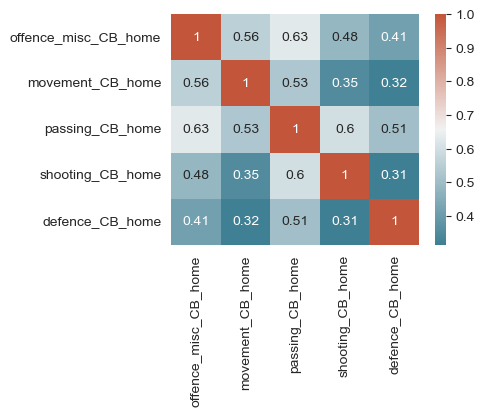

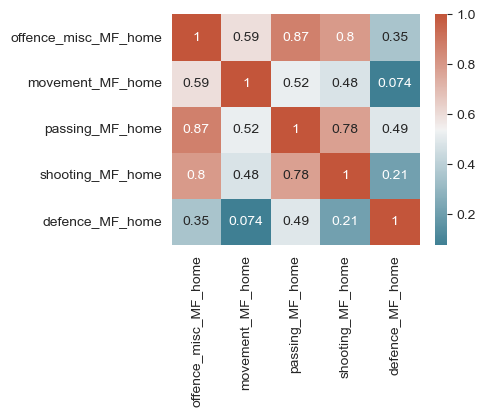

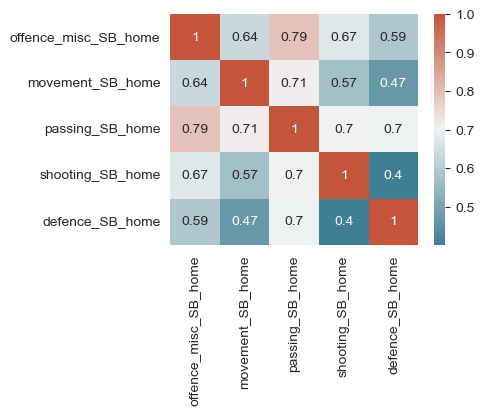

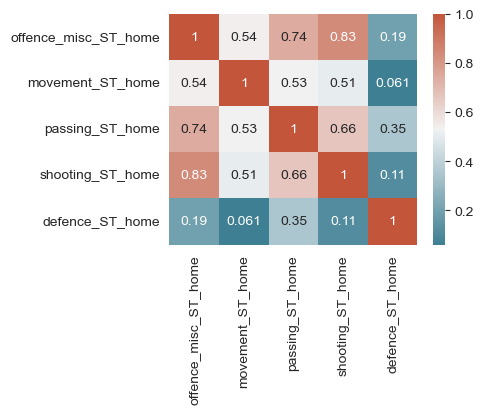

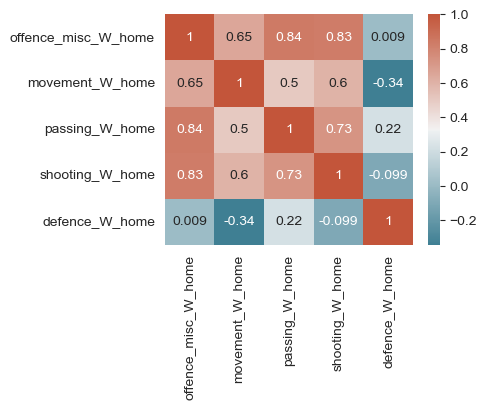

In [21]:
# Plot correlation heatmap by position
for pos in ['CB', 'MF', 'SB', 'ST', 'W']:
    cols_heat = [col for col in X.columns if pos +'_home' in col]
    df_heat = X[cols_heat]
    plt.subplots(figsize=(4,3))
    sns.heatmap(df_heat.corr(),annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

#### Observations: 
##### - there are constant high correlations between 'offence_misc',  'passing' and 'shooting' of MF, ST, and W, they should be merged
##### - there are constant high correlations between 'offence_misc' and  'passing' of SB, they should be merged

In [22]:
model_df1_n['offence_misc_MF_home'] = (model_df1_n['offence_misc_MF_home'] + model_df1_n['passing_MF_home']
                                       + model_df1_n['shooting_MF_home'])/3
model_df1_n['offence_misc_ST_home'] = (model_df1_n['offence_misc_ST_home'] + model_df1_n['passing_ST_home']
                                       + model_df1_n['shooting_ST_home'])/3
model_df1_n['offence_misc_W_home'] = (model_df1_n['offence_misc_W_home'] + model_df1_n['passing_W_home']
                                       + model_df1_n['shooting_W_home'])/3
model_df1_n['offence_misc_SB_home'] = (model_df1_n['offence_misc_ST_home'] + model_df1_n['passing_ST_home'])/2

In [23]:
model_df1_n['offence_misc_MF_away'] = (model_df1_n['offence_misc_MF_away'] + model_df1_n['passing_MF_away']
                                       + model_df1_n['shooting_MF_away'])/3
model_df1_n['offence_misc_ST_away'] = (model_df1_n['offence_misc_ST_away'] + model_df1_n['passing_ST_away']
                                       + model_df1_n['shooting_ST_away'])/3
model_df1_n['offence_misc_W_away'] = (model_df1_n['offence_misc_W_away'] + model_df1_n['passing_W_away']
                                       + model_df1_n['shooting_W_away'])/3
model_df1_n['offence_misc_SB_away'] = (model_df1_n['offence_misc_ST_away'] + model_df1_n['passing_ST_away'])/2

In [24]:
model_df1_n = model_df1_n.drop(columns = ['passing_MF_home', 'shooting_MF_home', 'passing_ST_home', 'shooting_ST_home',
                                         'passing_W_home', 'shooting_W_home', 'passing_ST_home'])

In [25]:
model_df1_n = model_df1_n.drop(columns = ['passing_MF_away', 'shooting_MF_away', 'passing_ST_away', 'shooting_ST_away',
                                         'passing_W_away', 'shooting_W_away', 'passing_ST_away'])

### 3. Quick view on logistic modeling insights using statsmodel

In [26]:
X = model_df1_n.drop(columns = 'result')

In [27]:
X_sm = sm.add_constant(X)

label_mapping = {'lose':0, 'tie':0.5, 'win':1}

y_sm = y.map(label_mapping)
log_reg = sm.Logit(y_sm, X_sm).fit()
print(log_reg.summary2())

Optimization terminated successfully.
         Current function value: 0.600340
         Iterations 5
                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.109     
Dependent Variable:  result            AIC:               19674.6848
Date:                2023-08-04 22:56  BIC:               19990.3857
No. Observations:    16318             Log-Likelihood:    -9796.3   
Df Model:            40                LL-Null:           -10999.   
Df Residuals:        16277             LLR p-value:       0.0000    
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      5.0000                                         
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
const                 0.0526   0.3903  0.1347 0.8929 -0.7125  0.8176
offence_misc_CB_home  0.0094

#### Observation: 
##### - Not all home attributes have positive coef. and not all away attributes have negative coef. which means the data contains noise

In [28]:
noise_cols = ['offence_misc_SB_home', 'movement_ST_home', 'defence_MF_home', 'defence_W_home', 'offence_misc_SB_away', 
             'passing_CB_away', 'defence_W_away']

In [29]:
Win = model_df1_n[model_df1_n['result'] == 'win']
Tie = model_df1_n[model_df1_n['result'] == 'tie']
Lose = model_df1_n[model_df1_n['result'] == 'lose']

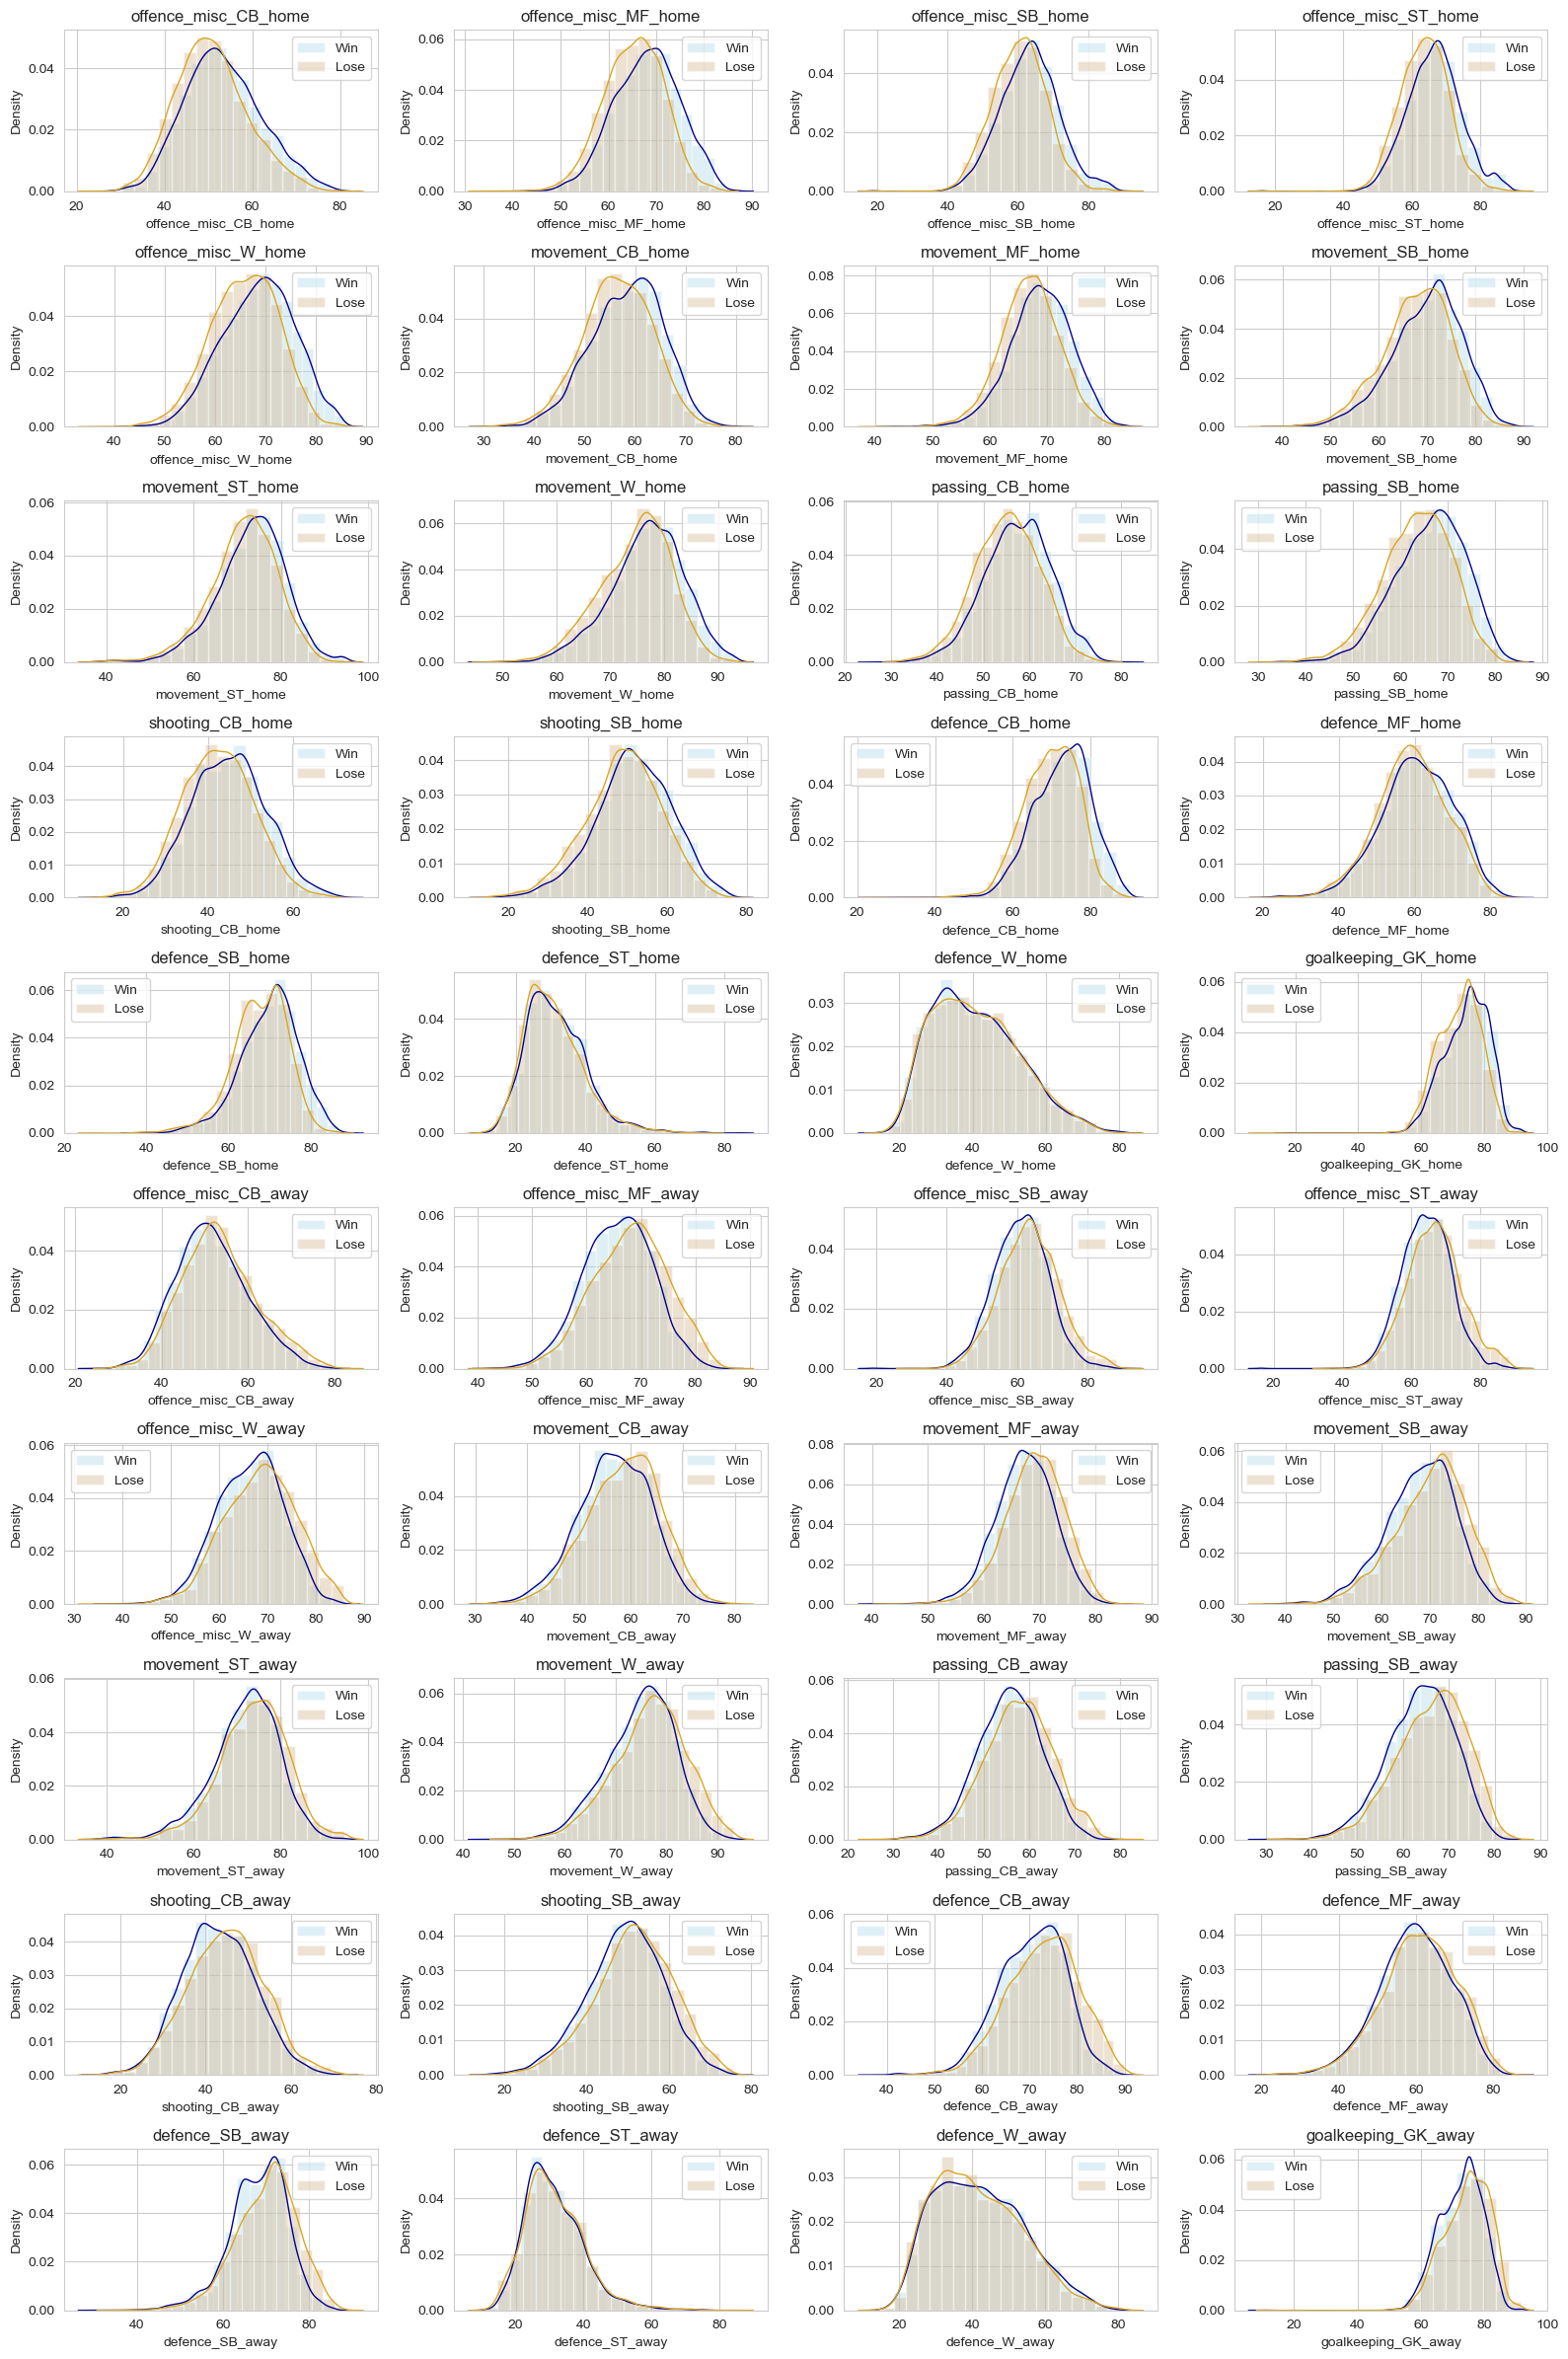

In [31]:
num_cols = 4
num_rows = int(np.ceil(len(X.columns) / num_cols))

fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(16, 24))
fig.subplots_adjust(hspace=0.5) 

axes = axes.flatten()

for i, col in enumerate(X.columns):
    ax = axes[i]
    sns.distplot(Win[col], hist=True, kde=True,
                 kde_kws={'linewidth': 1, 'color': 'darkblue'}, bins=20, color='lightblue', label='Win', ax=ax)
    sns.distplot(Lose[col], hist=True, kde=True,
                 kde_kws={'linewidth': 1, 'color': 'goldenrod'}, bins=20, color='tan', label='Lose', ax=ax)
    ax.set_title(col)
    ax.legend()

plt.tight_layout()
plt.show()

In [32]:
model_df1_n.to_csv('../dataset/model_df1_n.csv', index = False)